In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.9 MB/s eta 0:00:00


In [46]:
import random, time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

from tqdm.auto import tqdm

n_episodes = 30  # play 30 games
eps = 1.0  # exploration rate, probability of choosing random action
eps_decay = 0.9900  # eps gets multiplied by this number each epoch...
min_eps = 0.1  # ...until this minimum eps is reached
gamma = 0.90  # discount
max_memory_size = 10000  # size of the replay memory
batch_size = 16  # batch size of the neural network training
min_length = 160  # minimum length of the replay memory for training, before it reached this length, no gradient updates happen
memory_parts = [
    "state",
    "action",
    "next_state",
    "reward",
    "done",
]  # nice names for the part of replay memory, otherweise the names are 0-5

Num GPUs Available:  0
Num CPUs Available:  1


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Learning A Model

In [48]:
Memory = namedtuple("Memory", memory_parts)  # a single entry of the memory replay


class ReplayMemory:
    def __init__(self, max_length=None):
        self.max_length = max_length
        self.memory = deque(maxlen=max_length)

    def store(self, data):
        self.memory.append(data)

    def _sample(self, k):
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        batch = self._sample(k)
        result = {}
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        return result

    def __len__(self):
        return len(self.memory)

In [49]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),  # Define input shape with Input layer
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2, activation="linear"),  # 2 actions: go left or go right
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [50]:
env = gym.make("CartPole-v1")
replay_memory = ReplayMemory(max_length=max_memory_size)

for episode in tqdm(range(n_episodes)):  # tqdm makes a nice proress bar
    state, _ = env.reset()
    done = False

    while not done:
        if random.random() < eps:
            action = env.action_space.sample()  # random action
        else:
            action = model.predict(state[np.newaxis, :], verbose=False).argmax()  # best action according to the model

        next_state, reward, done, _, _ = env.step(action)
        memory = Memory(state, action, next_state, reward, done)
        replay_memory.store(memory)

        if len(replay_memory) >= min_length:
            batch = replay_memory.structured_sample(batch_size)  # get samples from the replay memory

            target_batch = batch["reward"] + gamma * model.predict(batch["next_state"], verbose=False).max(axis=1) * (
                1 - batch["done"]
            )  # R(s, a) + γ·maxₐ N(s') if not a terminal state, otherwise R(s, a)
            targets = model.predict(batch["state"], verbose=False)
            targets[
                range(batch_size), batch["action"]
            ] = target_batch  # set the target for the action that was done and leave the outputs of other 3 actions as they are

            model.fit(batch["state"], targets, verbose=False, batch_size=batch_size)  # train for one epoch

        state = next_state
    if episode % 100 == 0:
      save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
      print (save_path)
      model.save(save_path)
    eps = max(min_eps, eps * eps_decay)
save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
print (save_path)
model.save(save_path)

  0%|          | 0/30 [00:00<?, ?it/s]

/content/drive/My Drive/my_QmodelB_0iterations.keras
/content/drive/My Drive/my_QmodelB_29iterations.keras


In [51]:
eps_decay = 0.9900
min_eps = 0.01
eps = 1.0
for i in range(1000):
  eps = max(min_eps, eps * eps_decay)
  if (i % 10==0):
    print (i, eps)

print(eps)

0 0.99
10 0.8953382542587163
20 0.8097278682212583
30 0.7323033696543974
40 0.6622820409839835
50 0.5989560064661611
60 0.5416850759668536
70 0.4898902730042049
80 0.44304798162617254
90 0.40068465295154065
100 0.36237201786049694
110 0.3277227574378037
120 0.2963865873992079
130 0.26804671691687404
140 0.24241664604458016
150 0.21923726936647234
160 0.19827425658891445
170 0.17931568359471056
180 0.16216989001100657
190 0.1466635416321037
200 0.13263987810938213
210 0.11995712819347792
220 0.10848707650771475
230 0.09811376736368599
240 0.08873233251530144
250 0.08024793100055952
260 0.07257479035344938
270 0.06563533949318151
280 0.05935942452475082
290 0.05368359952302266
300 0.0485504851305729
310 0.043908188485071616
320 0.03970977861200675
330 0.03591281197926689
340 0.032478903417210436
350 0.029373338066467324
360 0.02656472043048682
370 0.024024656984952448
380 0.021727469135426065
390 0.019649933621386378
400 0.017771047742294682
410 0.016071817032256998
420 0.014535063236794

# Test Learned Models

In [52]:
## Choose Model
version = 1
models = [(0, '1qE_-qnJERonxGoGQTgm3UiRIIPpPUxnD'), (29, '1-1AiiK8BADbLNjCtCwJtZCTDBsRWSDZo')]

!gdown {models[version][1]}
save_path=f'my_QmodelB_{models[version][0]}iterations.keras'
print(save_path)

Downloading...
From: https://drive.google.com/uc?id=1-1AiiK8BADbLNjCtCwJtZCTDBsRWSDZo
To: /content/my_QmodelB_29iterations.keras
100% 148k/148k [00:00<00:00, 18.0MB/s]
my_QmodelB_29iterations.keras


In [53]:
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf

from tensorflow.keras.models import load_model

model = load_model(save_path, compile=False)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

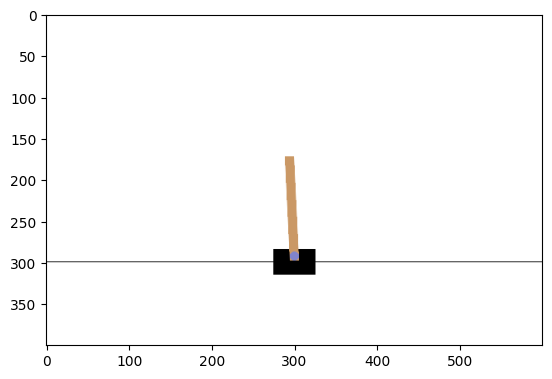

action=1, total_reward=1.0


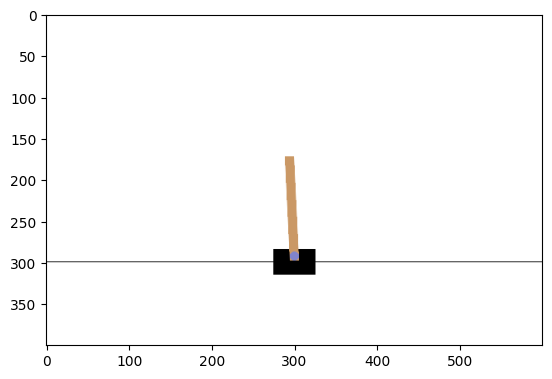

In [54]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
state_image=env.render()
plt.imshow(state_image)
plt.show()

state_image=env.render()
action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
state, reward, done, _, _ = env.step(action)
total_reward += reward
print (f"{action=}, {total_reward=}")
state_image=env.render()
plt.imshow(state_image)
plt.show()

In [55]:
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0

while not done and total_reward < 500:  # force end the game after 500 time steps because the model is too good!
    env.render()
    action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print (f"{total_reward=}")

total_reward=10.0


In [21]:
env.close()

##Discussion##
The 3 changes I made were the following:

**Changes in Model Definition**

The original model definition in the starter code was set to 1000. However, this is a high number of episodes to be run in the cloud. To do a comparable analysis I first run the model with 20 episodes and then increased it to 30.

With 20 episodes, I obtained a reward of 8 which is overall a low reward. With the change to 30 episodes, my reward increased to 11. This can lead me to think that the higher the episodes, the higher the reward is going to be. It is accurate to assume that with the proposed 1000 episodes, the reward would be even higher.

**Epsilon Decay Changes**

The original epsilon decay was set to 0.9975. With this epsilon decay, the convergence happens after 990 episodes.

With the change that made epsilon decay to be 0.9900, the convergence changes and happens at around 460 episodes. Note that with this decrease in epsilon decays, I got to increase the reward from 11 to 17 with the same 30 episodes. This is because the convergence happened faster

**Gamma Changes**
For this 3rd change, I reduced the gamma from 0.95 to 0.9. Note that until now, with a gamma of 0.95 the highest reward I was able to get was 17. When dicreasing the gamma to 0.9 the reward decreased to 10. This is because gamma represents a bigger loss with each episode. This may be due to that the model tried way too many different transitions in the exploration and since the loss was higher, the final reward was lower.